In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import csv
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure

**Nettyage des données**

In [ ]:
# ============================================================
# CLEANING PEMS MULTI-STATIONS (VERSION AMÉLIORÉE)
# Colonnes conservées (ordre final) :
# timestamp, station_id, avg_speed, total_flow, avg_occupancy, pct_observed
#
# Index PeMS :
# 0 timestamp | 1 station | 8 %obs | 9 flow | 10 occ | 11 speed
#
# Ajouts importants :
# 1) Supprime pct_observed == 0 (données non observées)
# 2) Interpolation PAR STATION sur avg_speed/flow/occ
# 3) pct_observed borné 0..100
# 4) Option: supprimer les lignes encore NaN après interpolation
# ============================================================

import pandas as pd
from pathlib import Path

# -------------------------
# CONFIG
# -------------------------
INPUT_DIR = Path("/content/drive/MyDrive/GEN-AI/traffic-anomaly-detection-pems-hybrid/VAE-LSTM-for-anomaly-detection/datasets/dataset_pems")
OUTPUT_DIR = INPUT_DIR / "cleaned_keep6_all_stations_v2"

DAYFIRST = False          # PeMS est souvent MM/DD/YYYY -> False
DROP_PCTOBS_ZERO = True   # recommandé : enlever les lignes pct_observed==0
DROP_REMAINING_NA = True  # recommandé : enlever les lignes encore NaN après interpolation

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Index PeMS exacts -> noms
KEEP_COLS = {
    0: "timestamp",
    1: "station_id",
    11: "avg_speed",
    9: "total_flow",
    10: "avg_occupancy",
    8: "pct_observed",
}

FINAL_ORDER = ["timestamp", "station_id", "avg_speed", "total_flow", "avg_occupancy", "pct_observed"]
NUM_COLS = ["avg_speed", "total_flow", "avg_occupancy", "pct_observed"]
INTERP_COLS = ["avg_speed", "total_flow", "avg_occupancy"]

# -------------------------
# Cleaning d'un fichier
# -------------------------
def clean_one_file(txt_path: Path):
    df = pd.read_csv(txt_path, header=None, sep=",", low_memory=False)

    if df.shape[1] <= max(KEEP_COLS.keys()):
        return {"file": txt_path.name, "status": "failed", "reason": f"colonnes insuffisantes: {df.shape[1]}"}

    # garder colonnes exactes (par index)
    df = df[list(KEEP_COLS.keys())].copy()
    df = df.rename(columns=KEEP_COLS)

    # parsing
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=DAYFIRST)
    df["station_id"] = pd.to_numeric(df["station_id"], errors="coerce")

    for c in NUM_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # nettoyage minimal
    df = df.dropna(subset=["timestamp", "station_id"])
    df = df.sort_values(["station_id", "timestamp"])

    # pct_observed borné (au cas où)
    df["pct_observed"] = df["pct_observed"].clip(lower=0, upper=100)

    # 1) supprimer lignes non observées
    if DROP_PCTOBS_ZERO:
        df = df[df["pct_observed"] > 0].copy()

    if len(df) == 0:
        return {"file": txt_path.name, "status": "skipped", "reason": "vide après filtrage pct_observed", "rows": 0}

    # 2) interpolation PAR STATION (seulement sur speed/flow/occ)
    df[INTERP_COLS] = (
        df.groupby("station_id")[INTERP_COLS]
          .apply(lambda x: x.interpolate(limit_direction="both"))
          .reset_index(drop=True)
    )

    # 3) option: supprimer les lignes encore NaN
    if DROP_REMAINING_NA:
        df = df.dropna(subset=INTERP_COLS)

    # ordre final des colonnes
    df = df[FINAL_ORDER]

    # sauvegarde
    out_path = OUTPUT_DIR / f"{txt_path.stem}_keep6_all_stations.csv"
    df.to_csv(out_path, index=False)

    return {"file": txt_path.name, "status": "ok", "rows": int(len(df)), "out_csv": str(out_path)}

# -------------------------
# RUN BATCH
# -------------------------
txt_files = sorted([p for p in INPUT_DIR.glob("*.txt") if p.is_file()])

logs = []
for p in txt_files:
    log = clean_one_file(p)
    logs.append(log)
    if log["status"] == "ok":
        print(f"[OK] {p.name} -> rows={log['rows']}")
    else:
        print(f"[{log['status'].upper()}] {p.name} -> {log.get('reason','')}")

log_df = pd.DataFrame(logs)
log_df.to_csv(OUTPUT_DIR / "cleaning_log.csv", index=False)

print("\nTerminé.")
print("Dossier sortie :", OUTPUT_DIR)
print("Résumé :", log_df["status"].value_counts().to_dict())


[OK] d03_text_station_5min_2026_01_01.txt -> rows=237031
[OK] d03_text_station_5min_2026_01_02.txt -> rows=229788
[OK] d03_text_station_5min_2026_01_03.txt -> rows=239122
[OK] d03_text_station_5min_2026_01_04.txt -> rows=232158
[OK] d03_text_station_5min_2026_01_05.txt -> rows=223477
[OK] d03_text_station_5min_2026_01_06.txt -> rows=236068
[OK] d03_text_station_5min_2026_01_07.txt -> rows=236849
[OK] d03_text_station_5min_2026_01_08.txt -> rows=238429
[OK] d03_text_station_5min_2026_01_09.txt -> rows=236974
[OK] d03_text_station_5min_2026_01_10.txt -> rows=240648
[OK] d03_text_station_5min_2026_01_11.txt -> rows=239439
[OK] d03_text_station_5min_2026_01_12.txt -> rows=237407
[OK] d03_text_station_5min_2026_01_13.txt -> rows=238581
[OK] d03_text_station_5min_2026_01_14.txt -> rows=235132
[OK] d03_text_station_5min_2026_01_15.txt -> rows=230215
[OK] d03_text_station_5min_2026_01_16.txt -> rows=237365
[OK] d03_text_station_5min_2026_01_17.txt -> rows=238743
[OK] d03_text_station_5min_2026

**DÉTECTION + PLOT + SAUVEGARDE NPZ**

In [7]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

# -------------------------
# CONFIG
# -------------------------
CLEAN_DIR = Path("/content/drive/MyDrive/GEN-AI/traffic-anomaly-detection-pems-hybrid/VAE-LSTM-for-anomaly-detection/datasets/dataset_pems/cleaned_keep6_all_stations_v2")
NPZ_DIR   = Path("/content/drive/MyDrive/GEN-AI/traffic-anomaly-detection-pems-hybrid/PEMS-processed-allstations-npz")
NPZ_DIR.mkdir(parents=True, exist_ok=True)

FEATURES = ["avg_speed", "total_flow", "avg_occupancy"]
T_UNIT = "5 min"

TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

MIN_T = 120   # garde-fou réaliste pour VAE+LSTM

# -------------------------
# 1) CONCAT ALL CLEAN CSV
# -------------------------
csv_files = sorted(CLEAN_DIR.glob("*_keep6_all_stations.csv"))
if not csv_files:
    raise FileNotFoundError(f"Aucun fichier trouvé dans {CLEAN_DIR}")

dfs = [pd.read_csv(f) for f in csv_files]
all_df = pd.concat(dfs, ignore_index=True)

all_df["timestamp"] = pd.to_datetime(all_df["timestamp"], errors="coerce")
all_df["station_id"] = pd.to_numeric(all_df["station_id"], errors="coerce")
all_df = all_df.dropna(subset=["timestamp", "station_id"])
all_df = all_df.sort_values(["station_id", "timestamp"]).reset_index(drop=True)

for c in FEATURES + ["pct_observed"]:
    all_df[c] = pd.to_numeric(all_df[c], errors="coerce")

# -------------------------
# 2) SAFE INTERPOLATION PER STATION
# -------------------------
all_df[FEATURES] = all_df.groupby("station_id")[FEATURES].transform(
    lambda x: x.interpolate(limit_direction="both")
)

all_df = all_df.dropna(subset=FEATURES).reset_index(drop=True)

# -------------------------
# 3) BUILD NPZ PER STATION (TRAIN / VAL / TEST)
# -------------------------
station_ids = all_df["station_id"].unique()
kept = 0
skipped = 0

for sid in station_ids:
    df_s = all_df[all_df["station_id"] == sid].copy()
    df_s = df_s.sort_values("timestamp").reset_index(drop=True)

    X = df_s[FEATURES].to_numpy(dtype=np.float32)
    timestamps = df_s["timestamp"].astype(str).to_numpy()
    T = len(X)

    if T < MIN_T:
        skipped += 1
        continue

    # -------------------------
    # SPLIT
    # -------------------------
    i_train = int(TRAIN_RATIO * T)
    i_val   = int((TRAIN_RATIO + VAL_RATIO) * T)

    if i_val <= i_train + 10:
        skipped += 1
        continue

    idx_split = (i_train, i_val)

    # -------------------------
    # NORMALISATION (TRAIN ONLY)
    # -------------------------
    train_m = X[:i_train].mean(axis=0)
    train_std = X[:i_train].std(axis=0) + 1e-8
    X_norm = (X - train_m) / train_std

    # score simple (optionnel)
    score = np.linalg.norm(X_norm, axis=1) / np.sqrt(X_norm.shape[1])

    out_path = NPZ_DIR / f"pems_station_{int(sid)}_multivar.npz"
    np.savez(
        out_path,
        t=np.arange(T, dtype=np.int64),
        t_unit=T_UNIT,
        timestamps=timestamps,
        features=np.array(FEATURES, dtype=object),
        X=X,
        X_norm=X_norm,
        score=score,
        idx_split=np.asarray(idx_split),
        train_m=train_m,
        train_std=train_std,
        station_id=int(sid),
    )

    kept += 1

print(f"NPZ générés : {kept}")
print(f"Stations ignorées (trop courtes) : {skipped}")
print(f"Dossier sortie : {NPZ_DIR}")

NPZ générés : 1676
Stations ignorées (trop courtes) : 0
Dossier sortie : /content/drive/MyDrive/GEN-AI/traffic-anomaly-detection-pems-hybrid/PEMS-processed-allstations-npz


**Exemple (détection + sauvegarde .npz)**

N = 148 idx_split = (0, 103)
Train mean per feature: {'avg_speed': np.float32(65.577675), 'total_flow': np.float32(105.75728), 'avg_occupancy': np.float32(0.03184078)}
Train std  per feature: {'avg_speed': np.float32(5.3022056), 'total_flow': np.float32(111.912025), 'avg_occupancy': np.float32(0.02816021)}
Detected anomalies (full): [71]
Detected anomalies (test): []
Saved npz: /content/drive/MyDrive/GEN-AI/traffic-anomaly-detection-pems-hybrid/PEMS-processed/pems_station_308511_multivar.npz


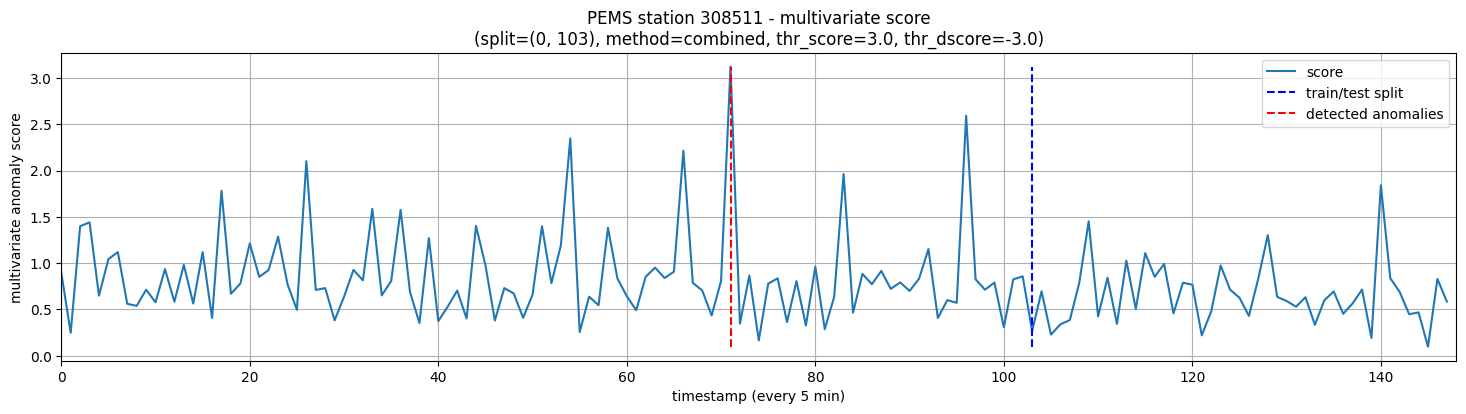

NPZ: /content/drive/MyDrive/GEN-AI/traffic-anomaly-detection-pems-hybrid/PEMS-processed/pems_station_308511_multivar.npz
Anomaly timestamps: ['2026-01-03 09:30:00']


In [ ]:
csv_path = "/content/drive/MyDrive/GEN-AI/traffic-anomaly-detection-pems-hybrid/VAE-LSTM-for-anomaly-detection/datasets/dataset_pems/cleaned_keep6_all_stations_v2/d03_text_station_5min_2026_01_03_keep6_all_stations.csv"

out = pems_detect_and_save_npz_multivar(
    csv_path=csv_path,
    station_id=308511,
    idx_split=(0, 8000),   # auto-ajusté si fichier court
    features=("avg_speed", "total_flow", "avg_occupancy"),
    method="combined",
    thr_score=3.0,
    thr_dscore=-3.0
)

print("NPZ:", out["npz_path"])
print("Anomaly timestamps:", out["anomaly_timestamps"][:10])
